In [1]:
# дивидентная доходность

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tinkoff.invest import Client, CandleInterval
from decimal import Decimal
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
token = 'ваш_тинькофф_токен'

In [4]:
# удаление времени, остаётся только дата
def convert_index(df):
    df = df.rename_axis('date').reset_index()
    df['date'] = df['date'].apply(lambda x: x.date())
    df['date'] =  pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

In [5]:
def units_nano_convert(d):
    # https://github.com/Tinkoff/invest-python/issues/45
    nano = d['nano'] / Decimal("10e8")
    price = d['units'] + float(nano)
    return price

In [6]:
def get_candles(figi, from_time, to_time):

    with Client(token) as client:
        data = client.market_data.get_candles(
                figi=figi,
                from_=from_time,
                to=to_time,
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            ).candles
        
    if len(data) == 0:
        return None
        
    candles = pd.DataFrame(data)

    for col in ['open', 'high', 'low', 'close']:
        candles[col] = candles[col].apply(units_nano_convert)

    candles = candles[['time', 'open', 'high', 'low', 'close']]

    # candles['time'] = candles['time'].dt.tz_convert('Europe/Moscow')
    candles.set_index('time', inplace=True)

    candles = candles.drop_duplicates()
    
    return candles

In [7]:
divs = pd.read_csv('divs.csv')
divs['date'] = pd.to_datetime(divs['date'], format='%d.%m.%Y')

In [8]:
divs

,ticker,date,div_sum
0,GAZP,2022-07-18,52.53
1,NVTK,2022-04-29,43.77
2,GMKN,2022-06-09,1166.22
3,TATN,2022-07-01,16.10
4,MTSS,2022-07-08,33.85


In [9]:
# Все figi и тикеры
with Client(token) as client:
    shares = client.instruments.shares()

all_stocks = pd.DataFrame(shares.instruments)
all_stocks = all_stocks[['ticker', 'figi']]

bc = all_stocks[all_stocks['ticker'].isin(divs['ticker'])]

In [10]:
bc = bc.merge(divs, on='ticker')

In [11]:
bc.head()

,ticker,figi,date,div_sum
0,GMKN,BBG004731489,2022-06-09,1166.22
1,GAZP,BBG004730RP0,2022-07-18,52.53
2,TATN,BBG004RVFFC0,2022-07-01,16.10
3,MTSS,BBG004S681W1,2022-07-08,33.85
4,NVTK,BBG00475KKY8,2022-04-29,43.77


In [12]:
MONTHS = 4
DAYS_SHOW = 60

In [13]:
# Все выходные дни
# !wget http://xmlcalendar.ru/data/ru/2022/calendar.txt

In [14]:
# Выходные дни (тинёк "условно" торгует GAZP по выходным, нам они будут не нужны)
holidays = np.loadtxt('calendar.txt', dtype=str)
holidays = pd.to_datetime(holidays)

In [15]:
df = pd.DataFrame()

for _, row in bc.iterrows():
    from_day = row['date'] - pd.offsets.DateOffset(months=MONTHS)
    
    temp = get_candles(row['figi'], from_day, row['date'])['close']
    
    # Расчёт доходности дивов от цены в %
    temp = np.round( (row['div_sum'] * 100) / temp, 2)
    
    temp.name = row['ticker']
    
    temp = convert_index(temp)
    
    # Удаляем выходные
    temp = temp[~temp.index.isin(holidays)]
    
    temp = temp.sort_index()
    temp = temp.fillna(method='ffill')
    
    date_now = pd.Timestamp.now()
    if row['date'] < date_now:
        temp = temp[-DAYS_SHOW:]
    else:
        # Если дата выплаты дивидентов в будущем, то оставляем до неё только рабочие дни (см график)
        days = np.sum( ~pd.date_range(date_now.date(), row['date']).isin(holidays) )
        temp = temp[-DAYS_SHOW+days:]
    
    temp = temp.reset_index(drop=True)
    # temp.index += 1
    
    
    df = pd.concat([df, temp], axis=1)

    # if row['ticker'] == 'GAZP':
    #     break
    
df.index = df.index[::-1]

In [16]:
df.shape

(60, 5)

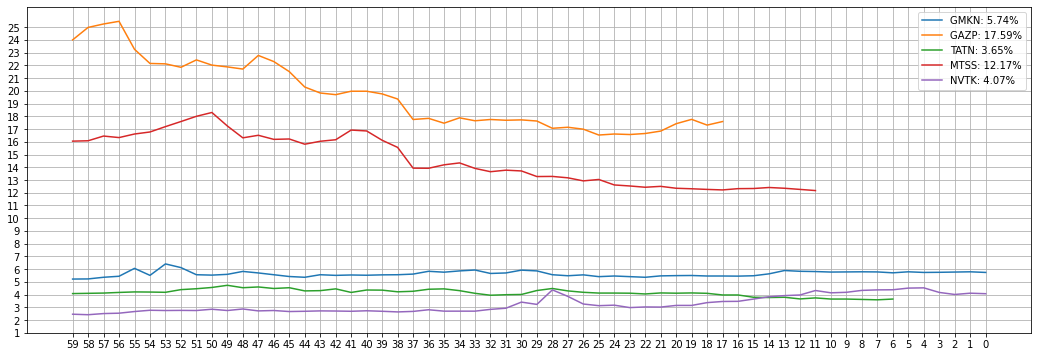

In [18]:
ax = df.plot(grid=True, xticks=df.index, yticks=range(1, round(df.max().max() + 1) ) )
plt.gca().invert_xaxis()
plt.legend( [col + ': ' + str(df[col][df[col].last_valid_index()]) + '%' for col in df.columns] )

ax.figure.savefig('divs_change.png', facecolor = 'white', dpi=200)